# Read the output of a Geant4 PositronSource simulation

## Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib ipympl
from matplotlib.ticker import AutoMinorLocator
import os
import uproot
import math
import re
from scipy import interpolate

from G4_utils import *
from G4_read_output_files import *

# Set the number of digits to show in pandas dataframes
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# tic
#import time
#start = time.time()

## Set input path and base filename

In [2]:
#path = "C:/DATI/Geant4/PositronSource-build/output/"
#path = "/home/paterno/geant4-apps/PositronSource-build/output/test/"
#name = "output_6GeV_W2.0mm_readPS_D50cm"
#name = "output_6GeV_W2.0mm_D50cm"
#name = "output_6GeV_W2.0mm_readPS_D0cm"
#name = "output_6GeV_W2.0mm_D0cm"
#conv_th = 11.6 #mm
#isMattiaTest = True

#path = "/home/paterno/geant4-apps/PositronSource-build/output/conventional_statistical_analysis/"
#name = "output_6GeV_conventional_0"
#conv_th = 17.6 #mm

#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_2.86GeV_sigma1.0mm_W5-20mm_conventional_gp/"
#name = "output_2.86GeV_W15.0mm_conventional"
#conv_th = 15 #mm

#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_2.86GeV_sigma1.0mm_W8-16mm_crystalline_gp/"
#name = "output_2.86GeV_W12.0mm_crystalline_mis0.000rad_pot0.050A"

#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W4-24mm_conventional_gp/"
#name = "output_6GeV_W17.0mm_conventional"
#conv_th = 17 #mm

#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W_radiator2mm_D50cm_target6-15mm_gp/"
#name = "output_6GeV_W2.0mm_D50cm_target13.0mm"
#conv_th = 13 #mm

#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_GT/"
#name = "output_6GeV_W2.0mm_D0cm_GT12mm_spheres1.1mm"
#conv_th = 12.0 #mm

#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W9-15mm_crystalline_gp/"
#name = "output_6GeV_W12.0mm_crystalline_mis0.000rad_pot0.050A"

#path = "C:/DATI/Geant4/PositronSource-build/output/test_G4_v2_2.86GeV/"
#path = "/home/paterno/geant4-apps/PositronSource-build/output/test_G4_v2_2.86GeV/"
path = "C:/DATI/Geant4/PositronSource-build/output/test_ch5/"
#path = "/home/paterno/geant4-apps/PositronSource-build/output/test_ch5/"
#name = "output_2.86GeV_W15.0mm_conventional"
#name = "output_2.86GeV_W12.0mm_crystalline_mis0.000rad_pot0.050A"
name = "output_6GeV_W2.0mm_conv8.0mm_D50cm"
conv_th = 8.0 #mm

#path = "/home/paterno/geant4-apps/PositronSource-build/output/thin_crystal/"
#name = "output_2.86GeV_W0.1mm_crystalline_mis0.000rad_pot0.050A"
#name = "output_2.86GeV_W0.1mm_random_1e7events"

#path = "C:/DATI/Geant4/PositronSource-build/output/results_2.86GeV_sigma1.0mm_W5-20mm_conventional_gp/"
#name = "output_2.86GeV_W15.0mm_conventional"
#path = "C:/DATI/Geant4/PositronSource-build/output/results_2.86GeV_sigma1.0mm_W8-16mm_crystalline_gp/"
#name = "output_2.86GeV_W12.0mm_crystalline_mis0.000rad_pot0.050A"
#path = "C:/DATI/Geant4/PositronSource-build/output/results_2.86GeV_sigma1.0mm_W12mm_crystalline_mis_HT_gp/"
#name = "output_2.86GeV_W12.0mm_crystalline_mis0.002rad_pot0.065A"

"""
#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W_radiator2mm_D0-60cm_target9mm_gp/"
path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W_radiator2mm_D0cm_target6-12mm_gp/"
Ein = 6 #GeV
sigma_in = 0.5 #mm
rad_th = 2.0 #mm
Dcm = 0 #cm
conv_th = 10.0 #mm
name = "output_%sGeV_W%smm_D%scm_target%smm" % (Ein, rad_th, Dcm, conv_th)
"""

'\n#path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W_radiator2mm_D0-60cm_target9mm_gp/"\npath = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W_radiator2mm_D0cm_target6-12mm_gp/"\nEin = 6 #GeV\nsigma_in = 0.5 #mm\nrad_th = 2.0 #mm\nDcm = 0 #cm\nconv_th = 10.0 #mm\nname = "output_%sGeV_W%smm_D%scm_target%smm" % (Ein, rad_th, Dcm, conv_th)\n'

## Save and export settings

In [3]:
# Figure save option
saveFigs = True

# Option to convert file for RF-Track
convertFileToRFTrack = True
setGaussianTimeShape = True
addID = False

## Set output path and desired variables

In [4]:
# Stripped name
purename = name.replace("output_", "")

# Define the output folder
outpath = path + "analysis_output/"
if not os.path.exists(outpath):
    os.makedirs(outpath)

# Quantity to be stored as results
case_list = []
yield_pos_list = []
yield_ele_list = []
yield_ph_list = []
yield_n_list = []
pos_mean_E_list = []
pos_spread_E_list = []
pos_mean_div_fit_list = []
pos_mean_size_fit_list = []
Edep_rad_list = []
Edep_conv_list = []
PEDD_list = []

## Read the root file with the scoring ntuples for virtual detectors

In [5]:
print("\nopening rf:", name ,".root file ...")

rf = uproot.open(path + name + ".root")
rf_content = [item.split(';')[0] for item in rf.keys()]
print('rf_content:', rf_content)

#screenID: 2=after the Radiator (if used), 0=before the Converter, 1=after the Converter (or the single-crystal)
#particle: Geant4 particle name
#x,y are in [mm]
#px,py,pz are in [MeV/c]
#t is in [ns]
#branches = ["screenID", "particle", "x", "y", "px", "py", "pz", "t", "eventID"]
df = rf['scoring_ntuple'].arrays(library='pd')

if 'eventID' in df:
    Nevents = len(np.array(df.eventID.unique()))
else:
    Nevents = 1e4
print("Nevents:", Nevents) #number of simulated events (primary particles)

df_rad_out = df[(df.screenID == 2)].copy().drop(["screenID"], axis=1)
df_conv_in = df[(df.screenID == 0)].copy().drop(["screenID"], axis=1)
df_conv_out = df[(df.screenID == 1)].copy().drop(["screenID"], axis=1)
#df_wrong = df[(df.screenID == -1)].copy().drop(["screenID"], axis=1)
del df


opening rf: output_6GeV_W2.0mm_conv8.0mm_D50cm .root file ...
rf_content: ['scoring_ntuple', 'edep_rad', 'edep_conv', 'edep_spheres', 'scoring_ntuple2']
Nevents: 1000


### Dataframes with phase-spaces (of $\gamma$/e-/e+/n) after the Radiator crystal
note: if D = 0 -> this is empty!

In [6]:
print(np.array(df_rad_out.particle.unique()))
print(df_rad_out.shape[0], '\n')

if df_rad_out.shape[0] > 0 :
    df_rad_out_n = df_rad_out[(df_rad_out.particle == "neutron")].copy()
    df_rad_out_ph = df_rad_out[(df_rad_out.particle == "gamma")].copy()
    df_rad_out_ele = df_rad_out[(df_rad_out.particle == "e-")].copy()
    df_rad_out_pos = df_rad_out[(df_rad_out.particle == "e+")].copy()
    
    print('neutrons:', df_rad_out_n.shape[0])
    print('photons:', df_rad_out_ph.shape[0])
    print('e-:', df_rad_out_ele.shape[0], ', e+:', df_rad_out_pos.shape[0], \
          '-> e-e+-:', df_rad_out_ele.shape[0] + df_rad_out_pos.shape[0], '\n')

    df_rad_out.head(5)

['gamma' 'e+' 'e-' 'neutron' 'proton']
22189 

neutrons: 16
photons: 17865
e-: 2753 , e+: 1553 -> e-e+-: 4306 



### Dataframes with phase-spaces (of $\gamma$/e-/e+/n) before the Converter crystal

In [7]:
print(np.array(df_conv_in.particle.unique()))
print(df_conv_in.shape[0], '\n')

if df_conv_in.shape[0] > 0 :
    df_conv_in_n = df_conv_in[(df_conv_in.particle == "neutron")].copy()
    df_conv_in_ph = df_conv_in[(df_conv_in.particle == "gamma")].copy()
    df_conv_in_ele = df_conv_in[(df_conv_in.particle == "e-")].copy()
    df_conv_in_pos = df_conv_in[(df_conv_in.particle == "e+")].copy()

    print('neutrons:', df_conv_in_n.shape[0])
    print('photons:', df_conv_in_ph.shape[0])
    print('e-:', df_conv_in_ele.shape[0], ', e+:', df_conv_in_pos.shape[0], \
          '-> e-/e+-:', df_conv_in_ele.shape[0] + df_conv_in_pos.shape[0], '\n')

    df_conv_in.head(5)

['gamma' 'e+' 'e-' 'neutron' 'proton']
20099 

neutrons: 1
photons: 16537
e-: 2296 , e+: 1264 -> e-/e+-: 3560 



### Dataframes with phase-spaces (of $\gamma$/e-/e+/n) after the Converter crystal
note: if the source is not hybrid -> this is empty!

In [8]:
print(np.array(df_conv_out.particle.unique()))
print(df_conv_out.shape[0], '\n')

if df_conv_out.shape[0] > 0 :
    df_conv_out_n = df_conv_out[(df_conv_out.particle == "neutron")].copy()
    df_conv_out_ph = df_conv_out[(df_conv_out.particle == "gamma")].copy()
    df_conv_out_ele = df_conv_out[(df_conv_out.particle == "e-")].copy()
    df_conv_out_pos = df_conv_out[(df_conv_out.particle == "e+")].copy()

    print('neutrons:', df_conv_out_n.shape[0])
    print('photons:', df_conv_out_ph.shape[0])
    print('e-:', df_conv_out_ele.shape[0], ', e+:', df_conv_out_pos.shape[0], \
          '-> e-e+-:', df_conv_out_ele.shape[0] + df_conv_out_pos.shape[0], '\n')

    df_conv_out.head(5)

['gamma' 'e-' 'e+' 'neutron' 'proton']
135929 

neutrons: 77
photons: 118524
e-: 9650 , e+: 7675 -> e-e+-: 17325 



## Plot the positron distribution at the Converter/Target exit [and correlate it with the photon distribution at the exit of the radiator crystal]

### Import the required libraries

In [9]:
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

#import succolib as sl #Mattia Soldani's package (install it with: pip install succolib)

def gaussian(x, a, b, c):
    import numpy as np
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

### Set plot style ###
import mplhep as hep
import plot_settings as settings

style = settings.style #use this with "import plot_settings as settings"
style['figure.figsize'] = (style['figure.figsize'][0], 8.50) #manual tweak to figure height
plt.style.use(style)

### Options for this calculation

In [10]:
if 'conventional' in name:
    inputType = "e-" 
else:
    inputType = "all" #set a value different from "all" only if it is a conventional source

bCutOnMomentum = False
MomentumCut = 5 #MeV

### Define data_in and data_out dataframes and add more parameters to them

Adapt dataframes to use Mattia Soldani's scripts

In [11]:
if df_rad_out.shape[0] > 0:
    data_in = df_rad_out.copy()
else:
    if df_conv_out.shape[0] > 0:
        data_in = df_conv_in.copy()
    else:
        data_in = df_rad_out.copy() #set an empty dataframe, because this is a single-volume (crystal or conventional) source
    
data_in["P"] = (data_in.px*data_in.px + data_in.py*data_in.py + data_in.pz*data_in.pz)**0.5 #MeV  
data_in = data_in[data_in.pz >= 0] #selecting only events (that should be) from the input beam
if bCutOnMomentum:
    data_in = data_in[data_in.P >= MomentumCut] #selecting only events with momentum > MomentumCut
data_in.pz = data_in.pz/1000 #MeV -> GeV
data_in.x = data_in.x/10 #mm -> cm
data_in.y = data_in.y/10 #mm -> cm
data_in["pt"] = (data_in.px**2 + data_in.py**2)**0.5 #MeV
data_in["thx"] = np.arctan(data_in.px/1000 / data_in.pz)*1000 #mrad
data_in["thy"] = np.arctan(data_in.py/1000 / data_in.pz)*1000 #mrad
data_in["tht"] = np.arctan(data_in.pt/1000 / data_in.pz)*1000 #mrad

if df_conv_out.shape[0] > 0:
    data_out = df_conv_out.copy() 
else: #this is the case of a single-volume (crystalline or conventional) source
    data_out = df_conv_in.copy()  

data_out["P"] = (data_out.px*data_out.px+data_out.py*data_out.py+data_out.pz*data_out.pz)**0.5 #MeV
if bCutOnMomentum:
    data_out = data_out[data_out.P >= MomentumCut] #selecting only events with momentum > MomentumCut
data_out.pz = data_out.pz/1000 #MeV -> GeV
data_out.x = data_out.x/10 #mm -> cm
data_out.y = data_out.y/10 #mm -> cm
data_out["pt"] = (data_out.px**2 + data_out.py**2)**0.5 #MeV
data_out["thx"] = np.arctan(data_out.px/1000 / data_out.pz)*1000 #mrad
data_out["thy"] = np.arctan(data_out.py/1000 / data_out.pz)*1000 #mrad
data_out["tht"] = np.arctan(data_out.pt/1000 / data_out.pz)*1000 #mrad

### Plot the angular distribution

In [12]:
# plot options
fitrange_ang = 17.45 #mrad (for angular distribution)
#if "crystalline" in path or "conventional" in path or "crystalline" in name or "conventional" in name:
#    fitrange_ang = 10. #mrad (for angular distribution)    
ang_plot_lim = (-50, 150) #mrad
fitrange = 0.2 #cm (for spatial distribution)
nBins = 200 #for spatial distribution
xRange = (-0.45, 0.45) #cm
xRange1 = (-10.5, 10.5) #cm
yUpperLim = 14 #for profiles (11, 14)

e+ beam divergence along X and Y from Gauss fit in (-17.45, 17.45) mrad range: [-42.76, inf] mrad


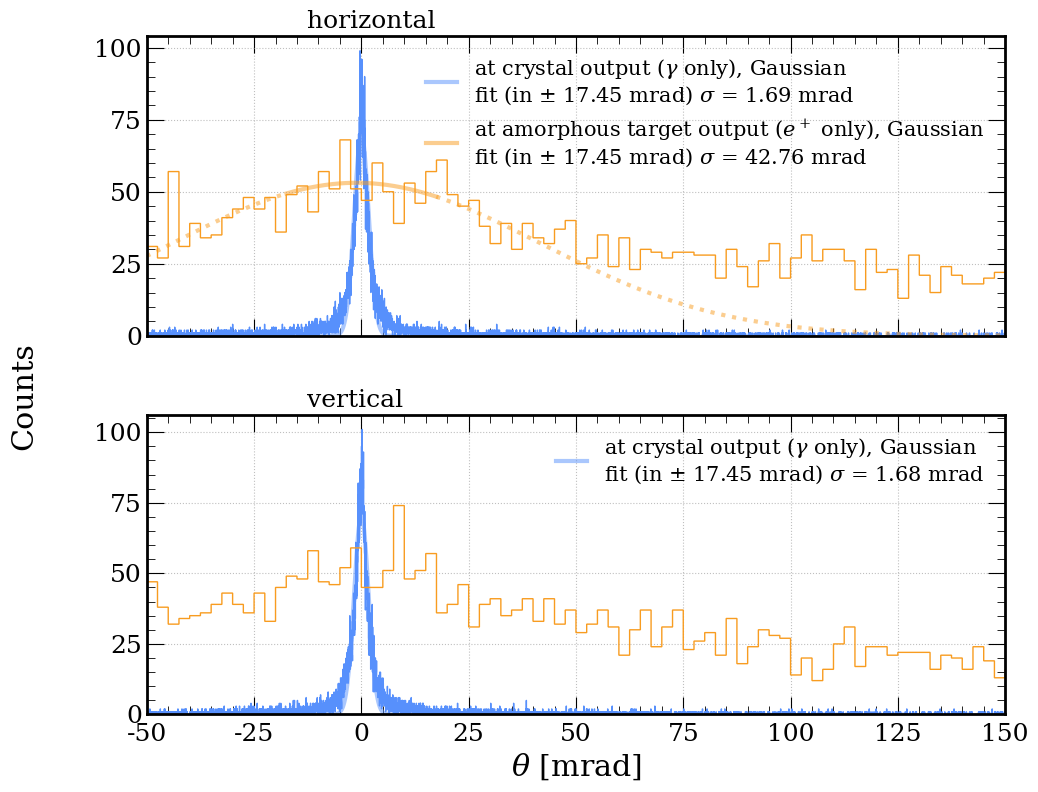

In [13]:
fig, ax = plt.subplots(nrows=2, sharex=True)

divergenceIn = [0, 0]
angleStdIn = [0, 0]
divergence = [0, 0]
angleStd = [0, 0]

if len(data_in) > 0:
    series = [data_in[(data_in.particle=="gamma" if inputType=="all" else data_in.particle=="e-")].thx, 
              data_in[(data_in.particle=="gamma" if inputType=="all" else data_in.particle=="e-")].thy]
    for i in (0, 1):
        hist = ax[i].hist(series[i], bins=15000, range=(-200, 200), histtype="step", color="C0")
        x, y = hist[1][:-1]+0.5*abs(hist[1][1]-hist[1][0]), hist[0]
        x, y = x[(x>-fitrange_ang) & (x<fitrange_ang)], y[(x>-fitrange_ang) & (x<fitrange_ang)]
        #par, _ = curve_fit(sl.fGaus, x, y)
        try:
            par, _ = curve_fit(f=gaussian, xdata=x, ydata=y, bounds=(-np.inf, np.inf))
        except:
            par = (1, 0, np.inf)
        xplot = np.linspace(-fitrange_ang, fitrange_ang, 200)
        xplot2 = np.linspace(-200, -fitrange_ang, 2000)
        xplot3 = np.linspace(fitrange_ang, 200, 2000)
        label = ("at crystal output"+r" ($\it{\gamma}$ only)" if inputType=="all" else \
                 "at amorphous target input"+r" ($\it{e}^-$ only)")+", Gaussian\n"+r"fit (in $\pm$ %.2f mrad)" % \
                 fitrange_ang+r" $\it{\sigma}$ = %.2f mrad" % abs(par[2])
        if abs(par[2]) < np.inf:
            #ax[i].plot(xplot, sl.fGaus(xplot, *par), c="C0", alpha=0.5, label=label)
            #ax[i].plot(xplot2, sl.fGaus(xplot2, *par), c="C0", ls=":", alpha=0.5)
            #ax[i].plot(xplot3, sl.fGaus(xplot3, *par), c="C0", ls=":", alpha=0.5)
            ax[i].plot(xplot, gaussian(xplot, *par), c="C0", alpha=0.5, label=label)
            ax[i].plot(xplot2, gaussian(xplot2, *par), c="C0", ls=":", alpha=0.5)
            ax[i].plot(xplot3, gaussian(xplot3, *par), c="C0", ls=":", alpha=0.5)
        
        divergenceIn[i] = abs(par[2])
        angleStdIn[i] = series[i].std()

        ax[i].set_yscale("linear")
        ax[i].set_xlim(ang_plot_lim)
        ax[i].set_title("                    "+("horizontal" if i==0 else "vertical"), loc="left")
        ax[i].legend(loc="upper right", fontsize="xx-small")
        ax[i].grid(True)

series = [data_out[(data_out.particle=="e+")].thx, data_out[(data_out.particle=="e+")].thy]
for i in (0, 1):
    hist = ax[i].hist(series[i], bins=800, range=(-1000, 1000), histtype="step", color="C1")
    x, y = hist[1][:-1]+0.5*abs(hist[1][1]-hist[1][0]), hist[0]
    x, y = x[(x>-fitrange_ang) & (x<fitrange_ang)], y[(x>-fitrange_ang) & (x<fitrange_ang)]
    #par, _ = curve_fit(sl.fGaus, x, y)
    try:
        par, _ = curve_fit(f=gaussian, xdata=x, ydata=y, bounds=(-np.inf, np.inf))
    except:
        par = (1, 0, np.inf)
    xplot = np.linspace(-fitrange_ang, fitrange_ang, 200)
    xplot2 = np.linspace(-200, -fitrange_ang, 2000)
    xplot3 = np.linspace(fitrange_ang, 200, 2000)
    label = "at amorphous target output"+r" ($\it{e}^+$ only)"+", Gaussian\n"+r"fit (in $\pm$ %.2f mrad)" % \
            fitrange_ang+r" $\it{\sigma}$ = %.2f mrad" % abs(par[2])
    if abs(par[2]) < np.inf:
        #ax[i].plot(xplot, sl.fGaus(xplot, *par), c="C1", alpha=0.5, label=label)
        #ax[i].plot(xplot2, sl.fGaus(xplot2, *par), c="C1", ls=":", alpha=0.5)
        #ax[i].plot(xplot3, sl.fGaus(xplot3, *par), c="C1", ls=":", alpha=0.5)
        ax[i].plot(xplot, gaussian(xplot, *par), c="C1", alpha=0.5, label=label)
        ax[i].plot(xplot2, gaussian(xplot2, *par), c="C1", ls=":", alpha=0.5)
        ax[i].plot(xplot3, gaussian(xplot3, *par), c="C1", ls=":", alpha=0.5)
    divergence[i] = abs(par[2])
    angleStd[i] = series[i].std()

    ax[i].set_yscale("linear")
    ax[i].set_xlim(ang_plot_lim)
    ax[i].set_title("                    "+("horizontal" if i==0 else "vertical"), loc="left")
    ax[i].legend(loc="upper right", fontsize="xx-small")
    ax[i].grid(True)

fig.supylabel("Counts", fontsize="small")
ax[1].set_xlabel(r"$\it{\theta}$ [mrad]")
fig.tight_layout()

if saveFigs:
    plt.savefig(outpath + 'eBeam_theta_distrib_' + purename + '.jpg')

print("e+ beam divergence along X and Y from Gauss fit in (-%.2f, %.2f) mrad range: [-%.2f, %.2f] mrad" \
      % (fitrange_ang, fitrange_ang, divergence[0], divergence[1]))

### Plot the spatial distribution

e+ beam size along X and Y from Gauss fit in (-0.20, 0.20) mm range: [-1.67, 1.59] mm


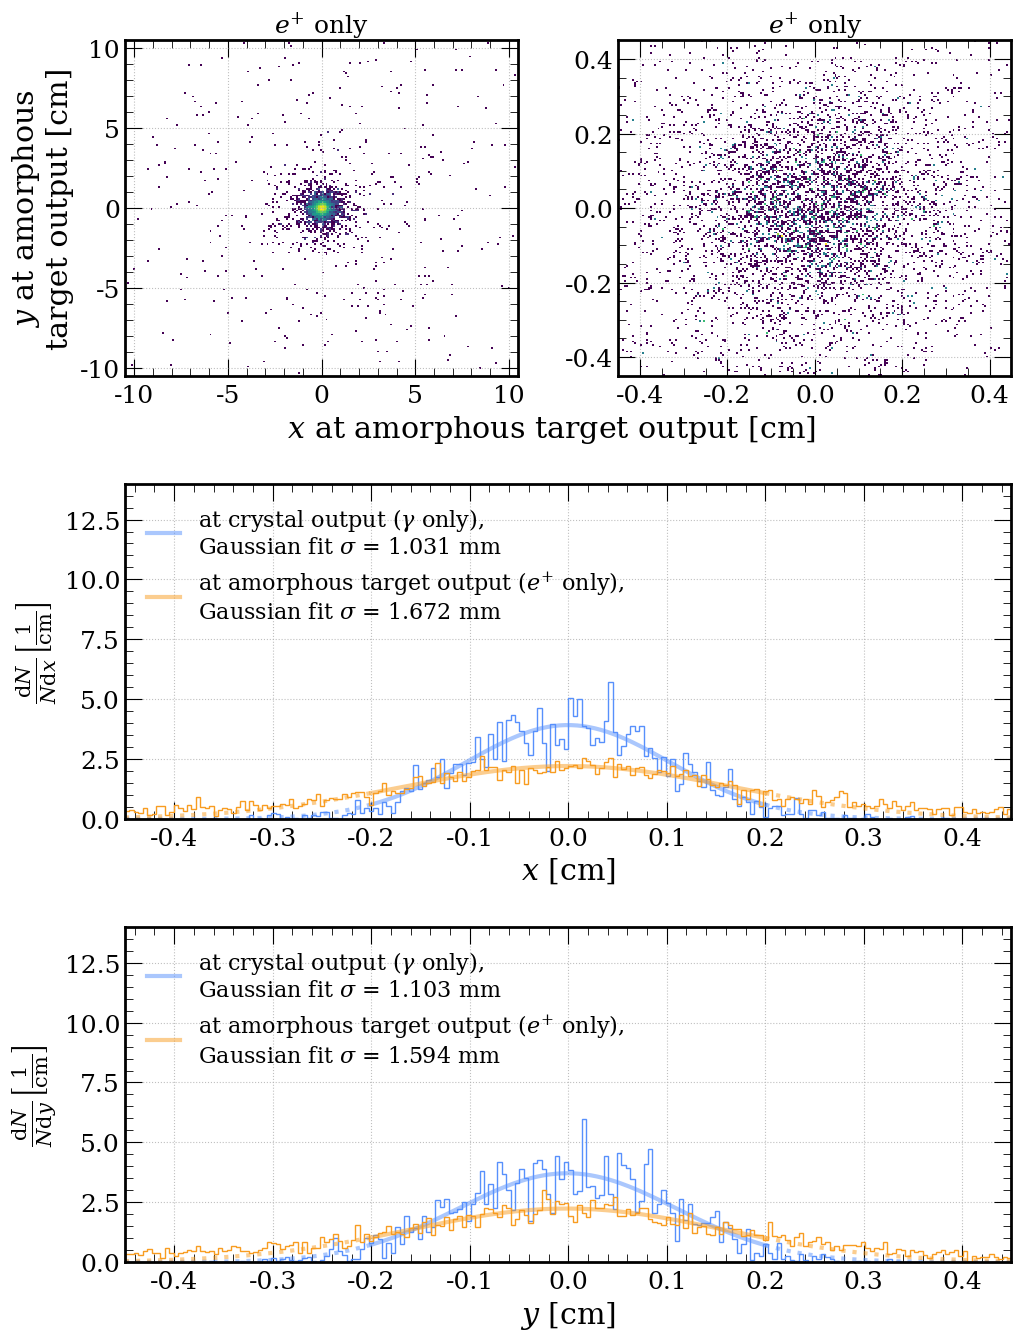

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(style['figure.figsize'][0], 14.0))
fig.subplots_adjust(wspace=-1)

beamSizeX, beamSizeY = [0, 0, 0], [0, 0, 0]

ax[0,0].set_title(r"$\it{e}^{+}$ only")
ax[0,1].set_title(r"$\it{e}^{+}$ only")

ax[0,1].hist2d(data_out[(data_out.particle=="e+")].x, data_out[(data_out.particle=="e+")].y, \
               bins=nBins, range=(xRange, xRange), norm=LogNorm())
ax[0,1].grid(True)
ax[0,0].hist2d(data_out[(data_out.particle=="e+")].x, data_out[(data_out.particle=="e+")].y, \
               bins=nBins, range=(xRange1, xRange1), norm=LogNorm())
ax[0,0].grid(True)

gs = ax[1,0].get_gridspec()
for ax0 in ax[1,:]:
    ax0.remove()
axdown = fig.add_subplot(gs[1,:])

if len(data_in) > 0:
    hist = axdown.hist(data_in[(data_in.particle=="gamma" if inputType=="all" else data_in.particle=="e-")].x, \
                       bins=nBins, histtype="step", range=xRange, density=True, color="C0") ;
    x, y = hist[1][:-1]+0.5*abs(hist[1][1]-hist[1][0]), hist[0]
    x, y = x[(x>-fitrange) & (x<fitrange)], y[(x>-fitrange) & (x<fitrange)]
    #par, _ = curve_fit(sl.fGaus, x, y)
    try:
        par, _ = curve_fit(f=gaussian, xdata=x, ydata=y, bounds=(-np.inf, np.inf))
    except:
        par = (1, 0, np.inf)
    xplot = np.linspace(-fitrange, fitrange, 200)
    xplot2 = np.linspace(xRange[0], -fitrange, 2000)
    xplot3 = np.linspace(fitrange, xRange[1], 2000)
    label = ("at crystal output"+r" ($\it{\gamma}$ only)" if inputType=="all" else \
             "at amorphous target input"+r" ($\it{e}^-$ only)")+",\nGaussian fit "+r"$\it{\sigma}$ = %.3f mm" % \
             abs(par[2]*10)
    if abs(par[2]) < np.inf:
        #axdown.plot(xplot, sl.fGaus(xplot, *par), c="C0", alpha=0.5, label=label)
        #axdown.plot(xplot2, sl.fGaus(xplot2, *par), c="C0", ls=":", alpha=0.5)
        #axdown.plot(xplot3, sl.fGaus(xplot3, *par), c="C0", ls=":", alpha=0.5)
        axdown.plot(xplot, gaussian(xplot, *par), c="C0", alpha=0.5, label=label)
        axdown.plot(xplot2, gaussian(xplot2, *par), c="C0", ls=":", alpha=0.5)
        axdown.plot(xplot3, gaussian(xplot3, *par), c="C0", ls=":", alpha=0.5)
    beamSizeX[0] = par[2]

hist = axdown.hist(data_out[(data_out.particle=="e+")].x, bins=nBins, histtype="step", \
                   range=xRange, density=True, color="C1")
x, y = hist[1][:-1]+0.5*abs(hist[1][1]-hist[1][0]), hist[0]
x, y = x[(x>-fitrange) & (x<fitrange)], y[(x>-fitrange) & (x<fitrange)]
#par, _ = curve_fit(sl.fGaus, x, y)
try:
    par, _ = curve_fit(f=gaussian, xdata=x, ydata=y, bounds=(-np.inf, np.inf))
except:
    par = (1, 0, np.inf)
xplot = np.linspace(-fitrange, fitrange, 200)
xplot2 = np.linspace(xRange[0], -fitrange, 2000)
xplot3 = np.linspace(fitrange, xRange[1], 2000)
label = "at amorphous target output"+r" ($\it{e}^{+}$ only)"+",\nGaussian fit "+r"$\it{\sigma}$ = %.3f mm" % abs(par[2]*10)
if abs(par[2]) < np.inf:
    #axdown.plot(xplot, sl.fGaus(xplot, *par), c="C1", alpha=0.5, label=label)
    #axdown.plot(xplot2, sl.fGaus(xplot2, *par), c="C1", ls=":", alpha=0.5)
    #axdown.plot(xplot3, sl.fGaus(xplot3, *par), c="C1", ls=":", alpha=0.5)
    axdown.plot(xplot, gaussian(xplot, *par), c="C1", alpha=0.5, label=label)
    axdown.plot(xplot2, gaussian(xplot2, *par), c="C1", ls=":", alpha=0.5)
    axdown.plot(xplot3, gaussian(xplot3, *par), c="C1", ls=":", alpha=0.5)
beamSizeX[1] = par[2]

gs = ax[2,0].get_gridspec()
for ax0 in ax[2,:]:
    ax0.remove()
axdown2 = fig.add_subplot(gs[2,:])

if len(data_in) > 0:
    hist = axdown2.hist(data_in[(data_in.particle=="gamma" if inputType=="all" else data_in.particle=="e-")].y, \
                        bins=nBins, histtype="step", range=xRange, density=True, color="C0") ;
    x, y = hist[1][:-1]+0.5*abs(hist[1][1]-hist[1][0]), hist[0]
    x, y = x[(x>-fitrange) & (x<fitrange)], y[(x>-fitrange) & (x<fitrange)]
    #par, _ = curve_fit(sl.fGaus, x, y)
    try:
        par, _ = curve_fit(f=gaussian, xdata=x, ydata=y, bounds=(-np.inf, np.inf))
    except:
        par = (1, 0, np.inf)
    xplot = np.linspace(-fitrange, fitrange, 200)
    xplot2 = np.linspace(xRange[0], -fitrange, 2000)
    xplot3 = np.linspace(fitrange, xRange[1], 2000)
    label = ("at crystal output"+r" ($\it{\gamma}$ only)" if inputType=="all" else \
             "at amorphous target input"+r" ($\it{e}^-$ only)")+",\nGaussian fit "+r"$\it{\sigma}$ = %.3f mm" % abs(par[2]*10)
    if abs(par[2]) < np.inf:
        #axdown2.plot(xplot, sl.fGaus(xplot, *par), c="C0", alpha=0.5, label=label)
        #axdown2.plot(xplot2, sl.fGaus(xplot2, *par), c="C0", ls=":", alpha=0.5)
        #axdown2.plot(xplot3, sl.fGaus(xplot3, *par), c="C0", ls=":", alpha=0.5)
        axdown2.plot(xplot, gaussian(xplot, *par), c="C0", alpha=0.5, label=label)
        axdown2.plot(xplot2, gaussian(xplot2, *par), c="C0", ls=":", alpha=0.5)
        axdown2.plot(xplot3, gaussian(xplot3, *par), c="C0", ls=":", alpha=0.5)
    beamSizeY[0] = par[2]

hist = axdown2.hist(data_out[(data_out.particle=="e+")].y, bins=nBins, histtype="step", range=xRange, density=True, color="C1")
x, y = hist[1][:-1]+0.5*abs(hist[1][1]-hist[1][0]), hist[0]
x, y = x[(x>-fitrange) & (x<fitrange)], y[(x>-fitrange) & (x<fitrange)]
#par, _ = curve_fit(sl.fGaus, x, y)
try:
    par, _ = curve_fit(f=gaussian, xdata=x, ydata=y, bounds=(-np.inf, np.inf))
except:
    par = (1, 0, np.inf)
xplot = np.linspace(-fitrange, fitrange, 200)
xplot2 = np.linspace(xRange[0], -fitrange, 2000)
xplot3 = np.linspace(fitrange, xRange[1], 2000)
label = "at amorphous target output"+r" ($\it{e}^{+}$ only)"+",\nGaussian fit "+r"$\it{\sigma}$ = %.3f mm" % abs(par[2]*10)
if abs(par[2]) < np.inf:
    #axdown2.plot(xplot, sl.fGaus(xplot, *par), c="C1", alpha=0.5, label=label)
    #axdown2.plot(xplot2, sl.fGaus(xplot2, *par), c="C1", ls=":", alpha=0.5)
    #axdown2.plot(xplot3, sl.fGaus(xplot3, *par), c="C1", ls=":", alpha=0.5)
    axdown2.plot(xplot, gaussian(xplot, *par), c="C1", alpha=0.5, label=label)
    axdown2.plot(xplot2, gaussian(xplot2, *par), c="C1", ls=":", alpha=0.5)
    axdown2.plot(xplot3, gaussian(xplot3, *par), c="C1", ls=":", alpha=0.5)
beamSizeY[1] = par[2]

ax[0,0].set_ylabel(r"$\it{y}$ at amorphous"+"\ntarget output [cm]")
ax[0,0].set_xlabel(r"                 $\it{x}$ at amorphous target output [cm]", loc="left")
axdown.set_xlabel(r"$\it{x}$ [cm]")
axdown.set_ylabel(r"$\frac{\mathrm{d}\it{N}}{\it{N}\mathrm{d}\it{x}}\left[\frac{1}{\mathrm{cm}}\right]$")
axdown.set_xlim((xRange[0], xRange[1]))
axdown.set_ylim((0, yUpperLim))
axdown.legend(loc="upper left", fontsize=16)
axdown.grid(True)
axdown2.set_xlabel(r"$\it{y}$ [cm]")
axdown2.set_ylabel(r"$\frac{\mathrm{d}\it{N}}{\it{N}\mathrm{d}\it{y}}\left[\frac{1}{\mathrm{cm}}\right]$")
axdown2.set_xlim((xRange[0], xRange[1]))
axdown2.set_ylim((0, yUpperLim))
axdown2.legend(loc="upper left", fontsize=16)
axdown2.grid(True)
fig.tight_layout()

if saveFigs:
    plt.savefig(outpath + 'eBeam_spatial_distrib_' + purename + '.jpg')

beamSizeXStd = [data_in.x.std(), data_out[(data_out.particle=="e+")].x.std(), data_out[(data_out.particle=="e+")].x.std()]
beamSizeYStd = [data_in.y.std(), data_out[(data_out.particle=="e+")].y.std(), data_out[(data_out.particle=="e+")].y.std()]

print("e+ beam size along X and Y from Gauss fit in (-%.2f, %.2f) mm range: [-%.2f, %.2f] mm" % \
      (fitrange, fitrange, np.abs(beamSizeX[1]*10), np.abs(beamSizeY[1]*10)))

## Plot the photon spectrum emitted by the Radiator crystal 

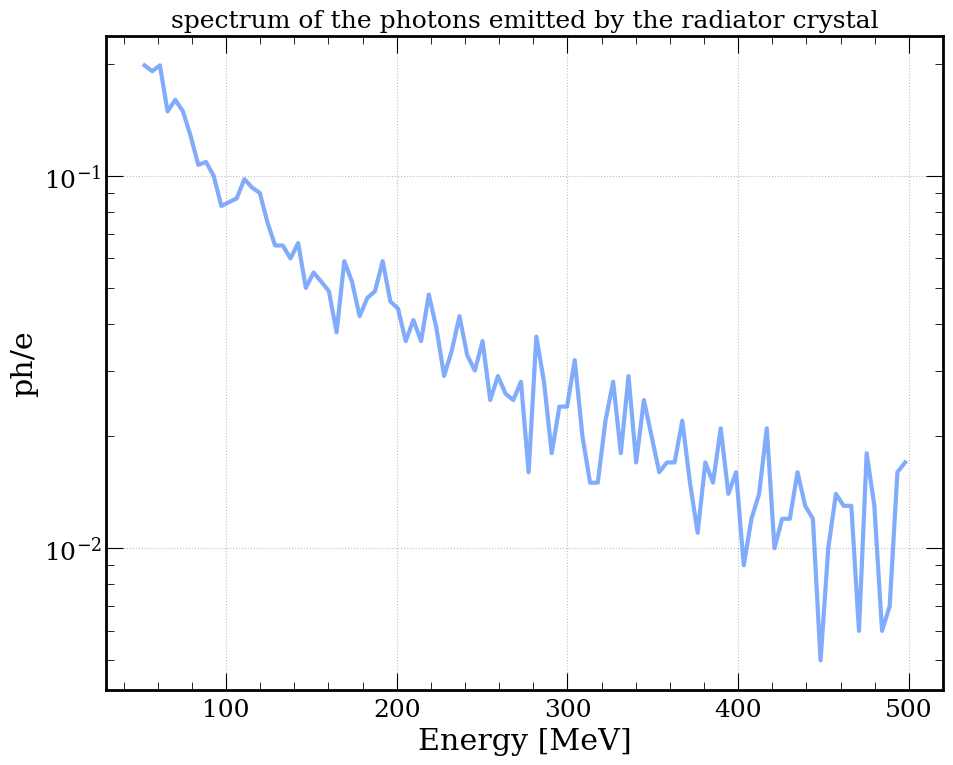

In [15]:
if len(data_in) > 0:
    df_ph_rad = data_in[(data_in.particle=="gamma")]
    nbin_gamma = 100
    range_gamma = (50, 500) #(50, 2450)
    IWantDensityInSpectrum = False
    IWantFlence = False
    df_ph_rad_sel = df_ph_rad[(df_ph_rad.P >= range_gamma[0]) & (df_ph_rad.P <= range_gamma[1])]
    ph_beam_area = 4*np.pi*np.std(df_ph_rad.x)*np.std(df_ph_rad.y)*100  
    spectrum_Eph_rad, edges_Eph_rad = np.histogram(df_ph_rad.P, density=IWantDensityInSpectrum, \
                                                   bins=nbin_gamma, range=range_gamma)
    bin_Eph_rad = edges_Eph_rad[:-1] + (edges_Eph_rad[1]-edges_Eph_rad[0])*0.5
    if not IWantDensityInSpectrum:
        spectrum_Eph_rad = spectrum_Eph_rad / Nevents
        if IWantFlence:
            spectrum_Eph_rad = spectrum_Eph_rad / ph_beam_area
            ylbl = 'ph/mm$^2/e$'
        else:
            ylbl = 'ph/e'
    else:
         ylbl = '1/N$\\times$dN/dE'
    spectral_int_Eph_rad = spectrum_Eph_rad * bin_Eph_rad
    plt.figure()
    plt.plot(bin_Eph_rad, spectrum_Eph_rad, alpha=0.75, label='')
    #plt.legend()
    plt.xlabel('Energy [MeV]')
    plt.ylabel(ylbl)
    #plt.ylabel('spectral intensity')
    plt.title('spectrum of the photons emitted by the radiator crystal')
    plt.grid(True)
    plt.yscale('log')
    if saveFigs:
        plt.savefig(outpath + 'Eph_rad_' + purename + '.jpg')
    plt.show()

## Histograms of Edep per event in the Radiator and the Converter
note: pay attention in case of read_PS...these plots make not much sense!

In [16]:
NbinsEdep = 50
fs = 20

### Radiator

total Edep in the Radiator per event: 16.84 MeV/e-



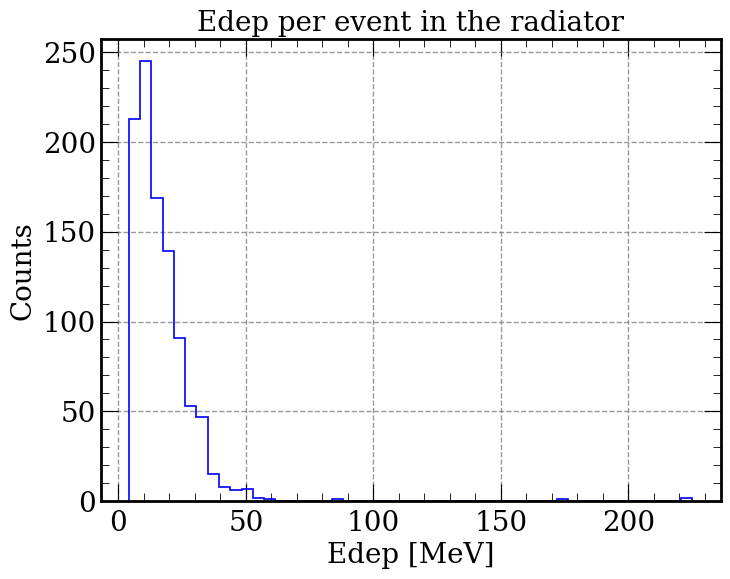

In [17]:
if 'edep_rad' in rf_content:   
    df_edep_rad = rf['edep_rad'].arrays(library='pd')
    edep_rad = np.array(df_edep_rad["edep"])
    
    print("total Edep in the Radiator per event:", round(np.sum(edep_rad)/Nevents, 2), "MeV/e-\n")
    
    if len(df_edep_rad) > 0:

        edep_rad_cut = edep_rad[edep_rad > 1]

        plt.figure(figsize=(8, 6))
        h_rad = plt.hist(edep_rad_cut, bins=NbinsEdep,
                         histtype="step", label="", density=False,
                         edgecolor="blue", linewidth=1.2, alpha=1.)
        plt.title('Edep per event in the radiator', fontsize=fs)
        plt.xlabel("Edep [MeV]", fontsize=fs)
        plt.ylabel("Counts", fontsize=fs)
        plt.xticks(fontsize=fs, rotation=0)
        plt.yticks(fontsize=fs, rotation=0)
        plt.grid(which="major", color="gray", linestyle="--", linewidth=1)
        if saveFigs:
            plt.savefig(outpath + 'Edep_distrib_rad_' + purename + '.jpg')
        plt.show() 
else:
    edep_rad = []

### Converter

total Edep in the Converter per event: 0.38 GeV/e-



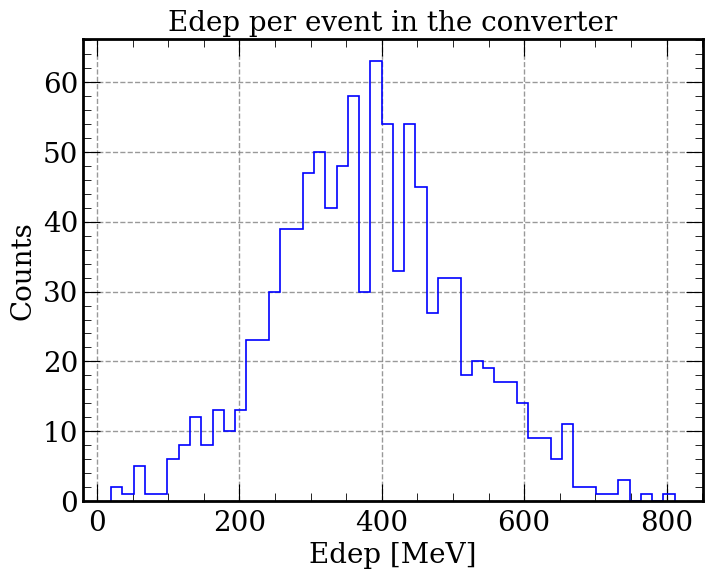

In [18]:
if 'edep_conv' in rf_content:
    df_edep_conv = rf['edep_conv'].arrays(library='pd')
    edep_conv = np.array(df_edep_conv["edep"])
    
    print("total Edep in the Converter per event:", round(np.sum(edep_conv)*1.e-3/Nevents, 2), "GeV/e-\n")
       
    if len(df_edep_conv) > 0 and not "_GT" in name:

        edep_conv_cut = edep_conv[edep_conv > 0]

        plt.figure(figsize=(8, 6))
        h_conv = plt.hist(edep_conv_cut, bins=NbinsEdep,
                          histtype="step", label="", density=False,
                          edgecolor="blue", linewidth=1.2, alpha=1.)
        plt.title('Edep per event in the converter', fontsize=fs)
        plt.xlabel("Edep [MeV]", fontsize=fs)
        plt.ylabel("Counts", fontsize=fs)
        plt.xticks(fontsize=fs, rotation=0)
        plt.yticks(fontsize=fs, rotation=0)
        plt.grid(which="major", color="gray", linestyle="--", linewidth=1)
        if saveFigs:
            plt.savefig(outpath + 'Edep_distrib_conv_' + purename + '.jpg')
        plt.show()
else:
    edep_conv = []

## Settings to read the built-in BoxMesh scorer with Edep in the Absorber (Converter or Radiator)

In [19]:
"""
if "crystalline" in path or "conventional" in path or "crystalline" in name or "conventional" in name:
    tranvsizeX = 20 #volume tranversal X size (mm)
    tranvsizeY = 20 #volume tranversal Y size (mm)
    print("crystalline or conventional source")
else:
    if 'isMattiaTest' in locals() and isMattiaTest:
        tranvsizeX = 199.75 #volume tranversal X size (mm)
        tranvsizeY = 199.75 #volume tranversal Y size (mm)   
        print("isMattiaTest")
    else:
        tranvsizeX = 100 #volume tranversal X size (mm)
        tranvsizeY = 100 #volume tranversal Y size (mm)
        print("is a hybrid Source")
"""        
tranvsizeX = 22         #volume tranversal X size (mm) <--------------
tranvsizeY = 22         #volume tranversal Y size (mm) <--------------   

print("tranverse sixe (X*Y) = %.1f x %.1f mm2" % (tranvsizeX, tranvsizeY))

#tranvsizeZ = conv_th   #volume tranversal Z size (mm) -> automatically retrieved below for each file!
if 'conv_th' in locals() and conv_th != '':                
    tranvsizeZ = conv_th
elif 'rad_th' in locals() and rad_th != '':
    tranvsizeZ = rad_th
else:
    try:
        tranvsizeZ = float(name.split('W')[1].split('mm_')[0])
    except:
        print('Enter the thickness [mm] of the target (or the Radiator if it is not an hybrid source):')
        tranvsizeZ = float(input())
    
print("tranvsizeZ = %.1f mm\n" % (tranvsizeZ))
        
IWantPlotVoxel = False
IWantPlotX0fract = False
X0 = 3.504              #crystal radiation length (mm)

normEvents = True;      #normalize w.r.t. simulated events (set always to true to compare with previous results)

axis_proj = 2           #0: axial, 1:sagittal, 2:coronal
proj_type = 1           #1: mean, 2: sum
p2m = 1                 #voxels around which to mean

plot_proj = True
reader_verb = True

titstr = ''

cmap2D = 'viridis'
Wfig = 12
Hfig = 8
fs = 20
ms = 6

tranverse sixe (X*Y) = 22.0 x 22.0 mm2
tranvsizeZ = 8.0 mm



## Read the built-in BoxMesh scorer with Edep in the Absorber

In [20]:
# read BoxMesh scorer
try:
    filename = path + name.replace("output", "Edep") + ".txt"
except:
    print('Enter the name of the file with the BoxMesh scorer results:')
    filename = float(input())
    
results_BoxMesh = read_Edep_BoxMesh(filename, normEvents, Nevents, 
                                    tranvsizeX, tranvsizeY, tranvsizeZ)
df_BoxMesh = results_BoxMesh[0]
voxel_coord = results_BoxMesh[1]
del results_BoxMesh

# retrieve variables form BoxMesh scorer
eDep = df_BoxMesh.eDep
eDepDensity = df_BoxMesh.eDepDensity
x = voxel_coord[0]
y = voxel_coord[1]
z = voxel_coord[2]
if x.shape[0] > 1:
    dx = x[1] - x[0]
else:
    dx = 0
if y.shape[0] > 1:
    dy = y[1] - y[0]
else:
    dy = 0
if z.shape[0] > 1:
    dz = z[1] - z[0]
else:
    dz = 0

# variables for contour plot of Edep
nx, ny , nz = [voxel_coord[i].shape[0] for i in range(3)]
X, Z = np.meshgrid(x, z)
icx = 0 if nx == 1 else int(X.shape[1]/2+1)
eDepMap = np.transpose(np.array(eDep).reshape(nx,ny,nz)[icx,:,:])
eDepDensityMap = np.transpose(np.array(eDepDensity).reshape(nx,ny,nz)[icx,:,:])

# Zprofile of Edep
ic = int(Z.shape[1]/2+1)
profileZ_eDep = np.zeros(nz)
profileZ_eDepDensity = np.zeros(nz)
for j in range(nz):
    if proj_type == 1:
        profileZ_eDep[j] = np.mean(eDepMap[j][ic-p2m:ic+p2m])
        profileZ_eDepDensity[j] = np.mean(eDepDensityMap[j][ic-p2m:ic+p2m])
    else:
        profileZ_eDep[j] = np.sum(eDepMap[j][ic-p2m:ic+p2m])
        profileZ_eDepDensity[j] = np.sum(eDepDensityMap[j][ic-p2m:ic+p2m])

PEDD = np.max(np.array(eDepDensity))
print("PEDD:", round(PEDD,2), "MeV/(mm^3 e-)")

PEDD: 83.91 MeV/(mm^3 e-)


### Contour and plofile plot of Edep (density) distribution

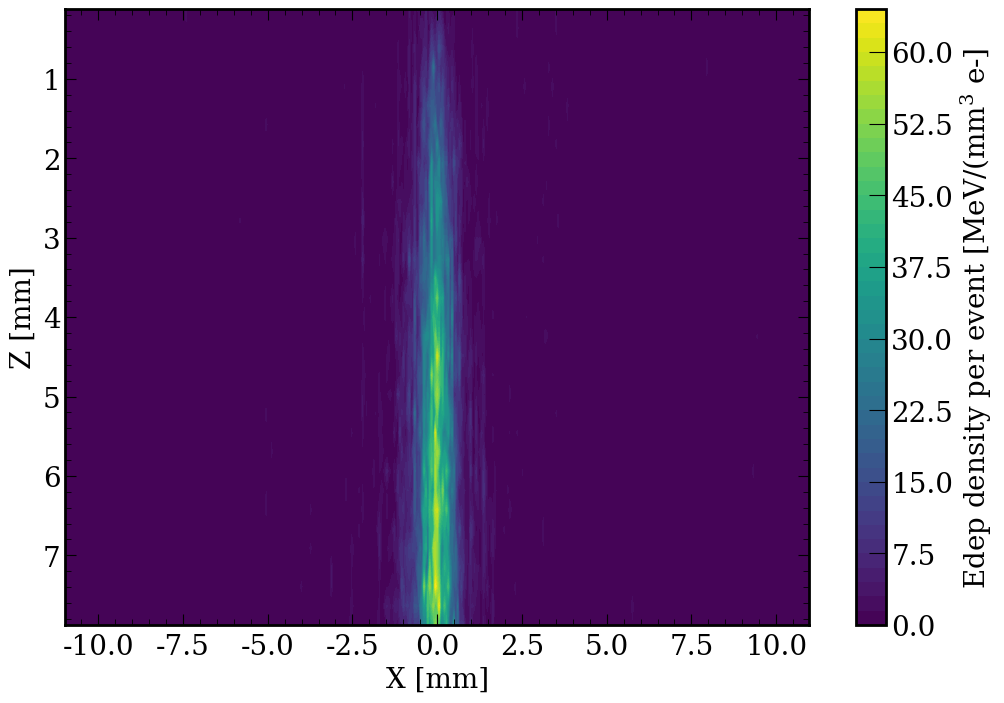

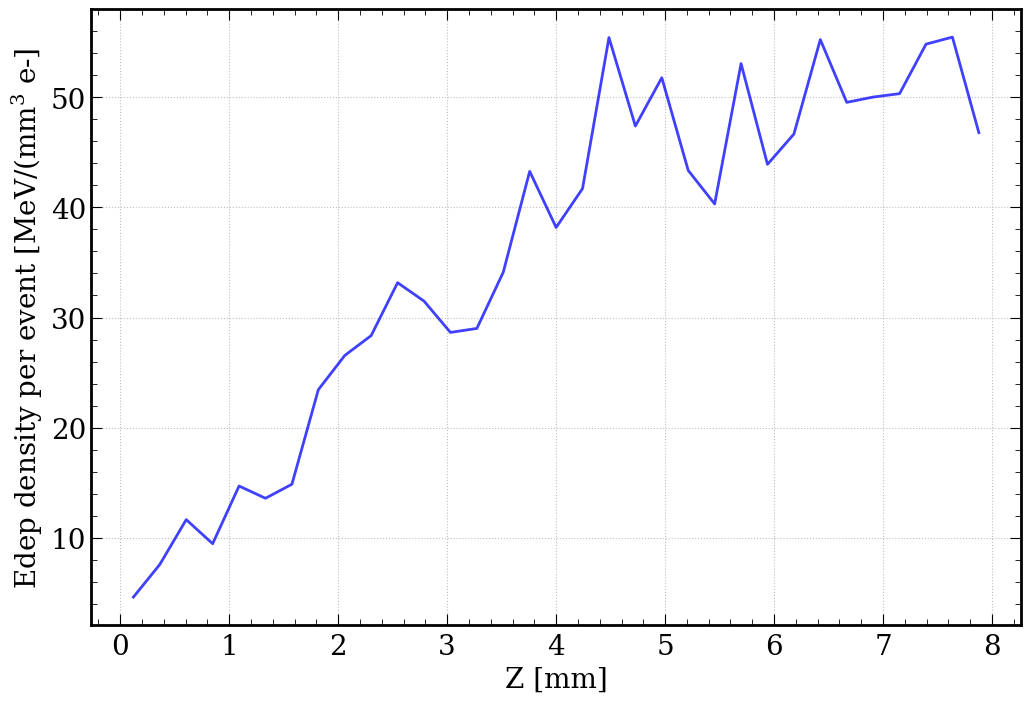

In [21]:
# set options
if normEvents:
    clbl = "Edep density per event [MeV/(mm$^3$ e-]"
else:
    clbl = "Edep density [MeV/mm$^3$]"

# contour plot of Edep
if eDepDensityMap.shape[0]>1 and eDepDensityMap.shape[1]>1: 
    plt.figure(figsize=(Wfig, Hfig))
    Nlev = 50
    if IWantPlotVoxel:
        plt.contourf(eDepDensityMap, Nlev, cmap='viridis')
        xlabel = "X [voxel]"
        ylabel = "Z [voxel]"        
    else:
        plt.contourf(X, Z, eDepDensityMap, Nlev, cmap='viridis')
        xlabel = "X [mm]"
        ylabel = "Z [mm]"
    #plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(clbl, fontsize=fs, rotation=90)
    plt.title(titstr, fontsize=fs)
    plt.xlabel(xlabel, fontsize=fs)
    plt.ylabel(ylabel, fontsize=fs, wrap=True)
    plt.xticks(fontsize=fs, rotation=0)
    plt.yticks(fontsize=fs, rotation=0)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(axis="both", which='major', direction='in', length=8)
    plt.gca().tick_params(axis="both", which='minor', direction='in', length=4)
    plt.grid(False)
    if saveFigs:
        plt.savefig(outpath + 'Edep_proj_' + purename + '.jpg')
    plt.show()

# plot Zprofile of Edep
if IWantPlotVoxel:
    xplot = np.linspace(0, nz-1, nz)
    ylabel = "Z [voxel]"  
else:
    xplot = z
    ylabel = "Z [mm]"
plt.figure(figsize=(Wfig, Hfig))
plt.plot(xplot, profileZ_eDepDensity, label="",
         color="blue", linestyle='-', linewidth=2, alpha=0.75,
         marker='', markersize=ms, markerfacecolor="Blue")
plt.title(titstr, fontsize=fs)
plt.xlabel(ylabel, fontsize=fs, wrap=True)
plt.ylabel(clbl, fontsize=fs, wrap=True)
plt.xticks(fontsize=fs, rotation=0)
plt.yticks(fontsize=fs, rotation=0)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().tick_params(axis="both", which='major', direction='in', length=8)
plt.gca().tick_params(axis="both", which='minor', direction='in', length=4)
plt.grid(True)
if saveFigs:
    plt.savefig(outpath + 'Edep_profileZ_' + purename + '.jpg')
plt.show()

### radius-vs-depth energy density

In [22]:
# plot options
rLim = 1.5 #mm
bScaleWidth = False
bLog = False
upperLim = 20 #MeV/(mm^3 e-)
ind_r_lsit = [0, 7, 15, 22] #6GeV: [0, 5, 10, 15]

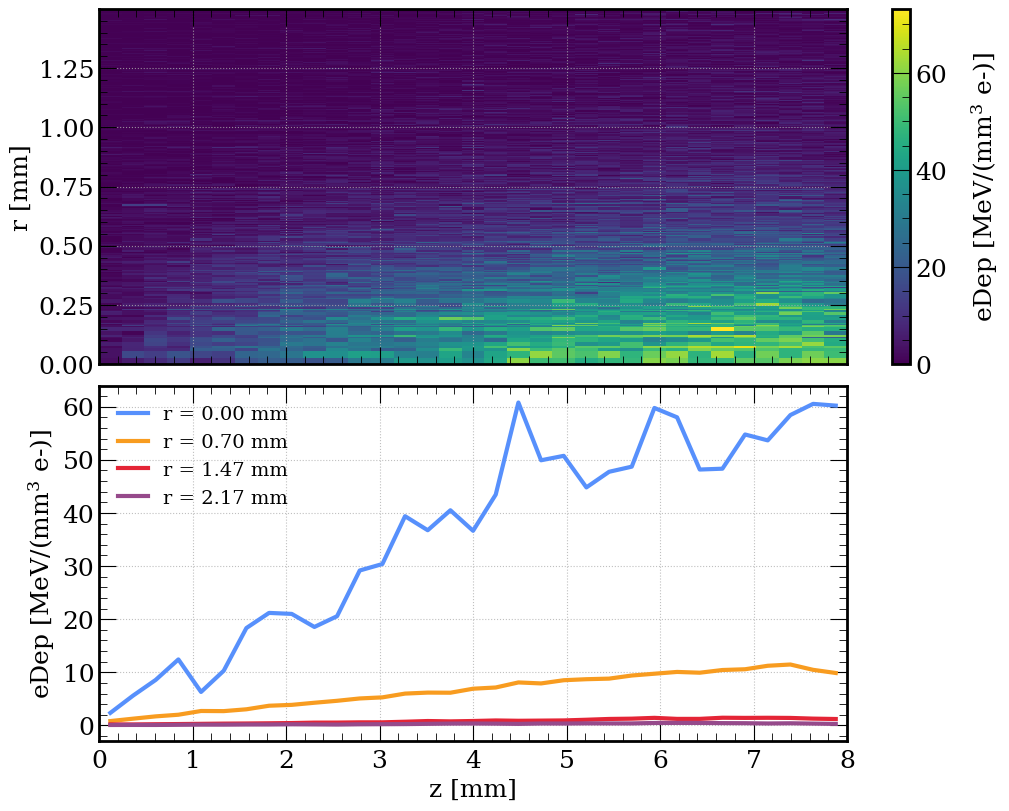

In [23]:
# radius-vs-depth energy density
bData = df_BoxMesh["r"] < rLim if rLim != None else df_BoxMesh["r"] < 1e5
Z, R = np.meshgrid(
    sorted(list(set(df_BoxMesh[bData]["z"]))),
    sorted(list(set(df_BoxMesh[bData]["r"]))),
)
ED = interpolate.griddata(
    (df_BoxMesh[bData]["z"], df_BoxMesh[bData]["r"]),
     df_BoxMesh[bData]["eDepDensity"], (Z, R), method='nearest'
)

if ED.shape[0]>1 and ED.shape[1]>1: 
    width = 5*max(df_BoxMesh["z"]) if bScaleWidth else 10
    fig, ax = plt.subplots(num="mesh", figsize=[width, 8], nrows=2, sharex=True, constrained_layout=True)

    # 2d plot
    plotmesh = ax[0].pcolormesh(Z, R, ED, shading="nearest", norm=LogNorm() if bLog else None)
    cbar = plt.colorbar(plotmesh, ax=ax[0])
    ax[0].grid()
    ax[0].set_ylim((0, max(df_BoxMesh[bData]["r"])))

    # 1d projection - energy density vs depth
    dr = (dx**2 + dy**2)**0.5
    for ind_r in ind_r_lsit:
        ind_r_eff = int(ind_r * 0.1 / dr)
        r_eff = dr * ind_r_eff
        bData = (df_BoxMesh["r"] >= (dr * (ind_r_eff - 0.5))) & \
                (df_BoxMesh["r"] <= (dr * (ind_r_eff + 0.5)))   
        temp = df_BoxMesh[bData][["z", "eDepDensity"]].sort_values(by=["z"])
        zlist = np.array(temp.z.unique())
        ymean = [np.mean(np.array(temp[temp["z"] == zi]["eDepDensity"])) for zi in zlist]
        ax[1].plot(
            #df_BoxMesh[bData]["z"], df_BoxMesh[bData]["eDepDensity"],
            zlist, ymean, #corrected by gpaterno
            label = "r = %.2f mm" % r_eff,
            marker='', linestyle='-'
        )
    #ax[1].set_ylim((0, upperLim))
    ax[1].grid()
    ax[1].legend(loc="upper left", fontsize=14)
    fs_local = 18

    ax[1].set_xlabel("z [mm]", fontsize=fs_local)
    ax[0].set_ylabel("r [mm]", fontsize=fs_local)
    ax[1].set_ylabel(r"eDep [MeV/(mm$^3$ e-)]", fontsize=fs_local)
    cbar.set_label(r"eDep [MeV/(mm$^3$ e-)]", rotation=90, labelpad=16, fontsize=fs_local)
    #fig.suptitle("e- beam features: %.2f GeV, %.1f mm" % (Ein, sigma_in))
    if saveFigs:
        plt.savefig(outpath + 'Edep_profileR_' + purename + '.jpg')
    plt.show()

## Get the positrons, analyze and export them

### Get the positrons

In [24]:
positrons = data_out[data_out.particle=="e+"].copy()
print("yield_e+:", round(positrons.shape[0] / Nevents, 2), "\n")

positrons

yield_e+: 7.67 



,particle,x,y,px,py,pz,t,eventID,P,pt,thx,thy,tht
38,e+,0.08,0.03,8.14,-8.01,0.12,1.79,80,116.70,11.42,70.01,-68.86,98.04
49,e+,0.10,0.04,3.91,-12.38,0.01,1.79,80,19.07,12.98,272.91,-725.14,748.79
56,e+,-6.36,5.87,-2.53,2.27,0.02,1.82,80,20.13,3.40,-126.84,113.90,169.67
144,e+,-0.11,0.11,1.57,-8.82,0.08,1.79,80,76.30,8.96,20.67,-115.86,117.66
149,e+,-0.12,0.08,-4.59,-1.10,0.07,1.79,80,70.99,4.73,-64.78,-15.59,66.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178122,e+,-0.00,0.05,-4.03,-0.40,0.02,1.80,29,24.82,4.05,-163.10,-16.50,163.91
178129,e+,-0.04,0.15,-11.88,2.90,0.02,1.80,29,21.88,12.23,-579.67,158.58,593.03
178135,e+,0.07,0.33,-2.39,1.80,0.00,1.80,29,3.49,2.99,-922.29,782.01,1026.35
178165,e+,-0.16,0.02,-1.41,-0.01,0.00,1.80,29,4.51,1.41,-317.69,-3.47,317.71


### Get the positrons produced in a given event

In [25]:
"""
eventID_sel = 840
positrons[positrons['eventID'] == eventID_sel]
"""

"\neventID_sel = 840\npositrons[positrons['eventID'] == eventID_sel]\n"

### Get positrons within a given energy (momentum) threshold

In [26]:
p_th = 100 #MeV
positrons[positrons["P"] < 100]

,particle,x,y,px,py,pz,t,eventID,P,pt,thx,thy,tht
49,e+,0.10,0.04,3.91,-12.38,0.01,1.79,80,19.07,12.98,272.91,-725.14,748.79
56,e+,-6.36,5.87,-2.53,2.27,0.02,1.82,80,20.13,3.40,-126.84,113.90,169.67
144,e+,-0.11,0.11,1.57,-8.82,0.08,1.79,80,76.30,8.96,20.67,-115.86,117.66
149,e+,-0.12,0.08,-4.59,-1.10,0.07,1.79,80,70.99,4.73,-64.78,-15.59,66.62
164,e+,-0.11,0.08,-2.04,3.02,0.02,1.79,80,23.23,3.64,-88.61,130.87,157.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178061,e+,0.10,0.14,-1.76,6.70,0.01,1.80,29,15.91,6.93,-122.25,437.61,450.54
178122,e+,-0.00,0.05,-4.03,-0.40,0.02,1.80,29,24.82,4.05,-163.10,-16.50,163.91
178129,e+,-0.04,0.15,-11.88,2.90,0.02,1.80,29,21.88,12.23,-579.67,158.58,593.03
178135,e+,0.07,0.33,-2.39,1.80,0.00,1.80,29,3.49,2.99,-922.29,782.01,1026.35


### Plot and Save the positron spectrum (taking into account angular and energy cuts)

Emean_pos: 50.45 MeV
Espread_pos: 1.78 (sigma/mu)
Emean_pos_cut (tht < 140.00 mrad): 122.69 MeV
Espread_pos_cut (tht < 140.00 mrad): 1.16 (sigma/mu)
fraction of positrons with energy < 100 MeV (0.71*sigma): 0.88



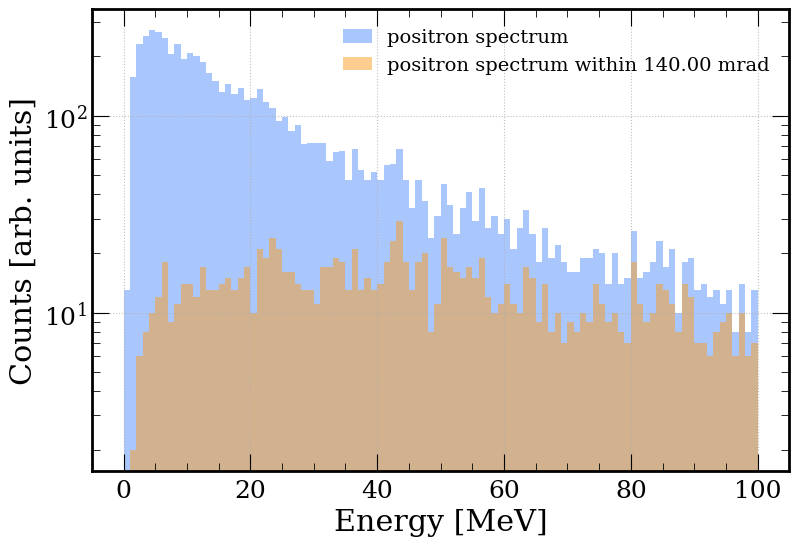

sum of positron spectrum: 6746
sum of positron spectrum within 140.00 mrad: 1291



In [27]:
save_spectrum = False

# Calculate positron beam energy distribution features
E_pos = (positrons.P**2 + 0.511**2)**0.5 #MeV
Emean_pos = np.mean(E_pos)
Estdev = np.std(E_pos)
Espread_pos = Estdev / Emean_pos
print("Emean_pos:", round(Emean_pos, 2), "MeV")
print("Espread_pos:", round(Espread_pos, 2), "(sigma/mu)")
#angle_cut = np.mean(divergence) #mrad
angle_cut = 140 #mrad
positrons_cut = positrons[positrons["tht"] < angle_cut]
#mask = (positrons.x**2+positrons.y**2)**0.5 < np.abs(np.mean([beamSizeX[1], beamSizeY[1]]))
#positrons_cut = positrons[mask] 
E_pos_cut = (positrons_cut.P**2 + 0.511**2)**0.5 #MeV
Emean_pos_cut = np.mean(E_pos_cut)
Estdev_cut = np.std(E_pos_cut)
Espread_pos_cut = Estdev_cut / Emean_pos_cut
print("Emean_pos_cut (tht < %.2f mrad):" % angle_cut, round(Emean_pos_cut, 2), "MeV")
print("Espread_pos_cut (tht < %.2f mrad):" % angle_cut, round(Espread_pos_cut, 2), "(sigma/mu)")
Eth = 100 # MeV
NposEth = len(E_pos.values[E_pos.values < Eth]) / len(E_pos.values)
NsigmaEth = Eth / (Emean_pos + Estdev)
print("fraction of positrons with energy < %.0f MeV (%.2f*sigma): %.2f\n" % (Eth, NsigmaEth, NposEth))

# Plot histogram of positrons energy
nbin_pos = 100
range_pos = (0, 100)
IWantDensity = False
plt.figure(figsize=(9, 6))
h = plt.hist(E_pos, density=IWantDensity, bins=nbin_pos, range=range_pos, alpha=0.5, \
             label='positron spectrum')
h2 = plt.hist(E_pos_cut, density=IWantDensity, bins=nbin_pos, range=range_pos, alpha=0.5, \
              label='positron spectrum within %.2f mrad' % (angle_cut))
plt.legend(fontsize=14)
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts [arb. units]')
plt.title('')
plt.grid(True)
plt.yscale('log')
if saveFigs:
    plt.savefig(outpath + 'eplusBeam_E_distrib_' + purename + '.jpg')
plt.show()

if not IWantDensity:
    print("sum of positron spectrum: %d" % sum(h[0]))
    print("sum of positron spectrum within %.2f mrad: %d\n" % (angle_cut, sum(h2[0])))
else:
    print("\n")
    
# Write the positron spectrum to a file
if save_spectrum:
    Eedges, spectrum = h[1], h[0]
    output_file = outpath + 'positron_spectrum_' + purename + '.txt'
    write_spectrum_to_G4file(Eedges, spectrum, output_file)
    _, spectrum_cut = h2[1], h2[0]
    output_file_cut = outpath + 'positron_spectrum_cut_%.1fmrad_' % angle_cut + purename + '.txt'
    write_spectrum_to_G4file(Eedges, spectrum_cut, output_file_cut)

### Convert the positron beam in RF-Track format (for tracking in the Capture system...)

In [28]:
convertFileToRFTrack = False

# Prepare the file to feed the RF-Track code to tack the positrons inside the Capture System/Positron Linac with
"""
NOTE: In RF-Track x'=px/pz=tan(thx) and y'=py/pz=tan(thy) (see the manual at page 22).
      The approximation x'=thx and y'=thy holds for small-angle only,
      which is the case of particle beams in accelators. However, 
      for example in a drift, we correctly have x2=x1+x'*(z2-z1) and y2=y1+y'*(z2-z1).
      In our case, positrons can exit the crystal also at large angles 
      and, for some of them, px and/or py can be (much) greater than pz. Thus,
      x' and y' are not angles, but tangents (which can tend to infinity) and 
      the fact that they are expressed in mrad means that they are multiplied by 1e-3.
      These particles would be lost in the capture section. However, if we want to
      calculate the tranverse phase space of the positron beam at the exit of the crystal,
      we must calculate properly (with arctan) thx, thy and set a proper angular cut.
"""
if convertFileToRFTrack:
    # Add variables to the original positron dataframe
    positrons["xp[mrad]"] = (positrons.px/(positrons.pz*1000))*1000
    positrons["yp[mrad]"] = (positrons.py/(positrons.pz*1000))*1000
    positrons["p[MeV/c]"] = positrons.P
    positrons["#x[mm]"] = positrons["x"]*10 #this is because they were previously converted form [mm] to [cm]
    positrons["y[mm]"] = positrons["y"]*10
    
    # Select only a set of variables
    if addID:
        positrons["ID"] = list(range(1, len(positrons)+1))
        positrons_out = positrons[["#x[mm]", "xp[mrad]", "y[mm]", "yp[mrad]", "p[MeV/c]", "ID"]]
    else:
        positrons_out = positrons[["#x[mm]", "xp[mrad]", "y[mm]", "yp[mrad]", "p[MeV/c]"]]

    # Guassian sampling in time, to keep the RF phases of the Hybrid similar to the conventional scheme
    c = 299792458 #m/s
    if setGaussianTimeShape:
        mean_value = 17.762 #mm/c
        std_value = 1.1950 #mm/c
        num_sample = len(positrons_out)
        gaussian_samples = np.random.normal(mean_value, std_value, num_sample)
        t = gaussian_samples
    else:        
        t = positrons.t * 1e-6 * c #ns -> mm/c
    positrons_out.insert(4, 't[mm/c]', t)

    # Save the positron phase-space to a txt file
    name_out = name.replace('output', 'positrons')
    positrons_out.to_csv(outpath + name_out + ".dat", index=False, sep=' ') 
    print("positron beam phase-space converted to RF-Track format!")

### Plot the positron beam time distribution

In [29]:
plot_t_distrib = False

if plot_t_distrib: 
    plt.figure(figsize=(10, 8))
    trLim = (-3*np.std(positrons.t) + np.mean(positrons.t), 3*np.std(positrons.t) + np.mean(positrons.t))
    plt.hist(positrons.t, density=False, bins=100, range=trLim, label='positrons original time distribution')
    if convertFileToRFTrack and setGaussianTimeShape:
        plt.hist(positrons_out["t[mm/c]"]*1e6/c, density=False, bins=100, \
                 label='positrons distribution after Gaussian shaping')
    plt.legend(fontsize=12)
    plt.xlabel('t [ns]')
    plt.ylabel('Counts [arb. units]')
    plt.title('')
    plt.grid(True)
    #plt.yscale('log')
    if saveFigs:
        plt.savefig(outpath + 'eplusBeam_t_distrib_' + purename + '.jpg')
    plt.show()

## Export the results of the simulation

In [30]:
# Fill the result list with those of the current simulation
case_list.append(purename)
yield_pos_list.append(round(data_out[(data_out.particle=="e+")].shape[0] / Nevents, 2))
yield_ele_list.append(round(data_out[(data_out.particle=="e-")].shape[0] / Nevents, 2))
yield_ph_list.append(round(data_out[(data_out.particle=="gamma")].shape[0] / Nevents, 2))
yield_n_list.append(round(data_out[(data_out.particle=="neutron")].shape[0] / Nevents, 2))
pos_mean_E_list.append(round(Emean_pos, 2))
pos_spread_E_list.append(round(Espread_pos, 2))   
pos_mean_div_fit_list.append(round(np.mean(divergence), 2))
pos_mean_size_fit_list.append(round(np.mean([np.abs(beamSizeX[1]*10), np.abs(beamSizeY[1]*10)]), 2))
Edep_rad_list.append(round(np.sum(edep_rad)/Nevents, 2))
Edep_conv_list.append(round(np.sum(edep_conv)*1e-3/Nevents, 2))
PEDD_list.append(round(PEDD, 2))

In [31]:
# Fill a dictionary with the results
results = { "case": case_list,
            "yield_e+": yield_pos_list,
            "yield_e-": yield_ele_list,
            "yield_ph": yield_ph_list,
            "yield_n": yield_n_list,
            "e+_mean_E[MeV]": pos_mean_E_list,
            "e+_spread_E[sigma/mu]": pos_spread_E_list,
            "e+_mean_div_fit[mrad]": pos_mean_div_fit_list,
            "e+_mean_size_fit[mm]": pos_mean_size_fit_list,
            "Edep_rad[MeV/e-]": Edep_rad_list,
            "Edep_conv[GeV/e-]": Edep_conv_list,
            "PEDD[MeV/(mm^3*e-)]": PEDD_list
          }

# Get a dataframe of the results
df_results = pd.DataFrame.from_dict(results)

# Export the results in a json file.
# pickle works pretty much the same, 
# but it I cannot directly have a look at it.
import json 
print("\nWriting json file with these data:")
for s in results:
    print("\t", s, ":", results[s])
outname = outpath + name.replace("output", "results")                 
with open(outname + ".json", "w") as file:    
    json.dump(results, file)
file.close()

"""
# Print the dataframe
import df2img
fig = df2img.plot_dataframe(
    df_results.round(2),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(1500, 500),
)
df2img.save_dataframe(fig=fig, filename=outpath+"df_results.jpg")
"""

# Print results
df_results

# toc
#print('\nThe execution took', round(time.time()-start, 0), 'seconds.\n')


Writing json file with these data:
	 case : ['6GeV_W2.0mm_conv8.0mm_D50cm']
	 yield_e+ : [7.67]
	 yield_e- : [9.65]
	 yield_ph : [118.52]
	 yield_n : [0.08]
	 e+_mean_E[MeV] : [np.float64(50.45)]
	 e+_spread_E[sigma/mu] : [np.float64(1.78)]
	 e+_mean_div_fit[mrad] : [np.float64(inf)]
	 e+_mean_size_fit[mm] : [np.float64(1.63)]
	 Edep_rad[MeV/e-] : [np.float64(16.84)]
	 Edep_conv[GeV/e-] : [np.float64(0.38)]
	 PEDD[MeV/(mm^3*e-)] : [np.float64(83.91)]


,case,yield_e+,yield_e-,yield_ph,yield_n,e+_mean_E[MeV],e+_spread_E[sigma/mu],e+_mean_div_fit[mrad],e+_mean_size_fit[mm],Edep_rad[MeV/e-],Edep_conv[GeV/e-],PEDD[MeV/(mm^3*e-)]
0,6GeV_W2.0mm_conv8.0mm_D50cm,7.67,9.65,118.52,0.08,50.45,1.78,inf,1.63,16.84,0.38,83.91


## Read scoring_ntuple2: features of the particles that exit (towards any direction) the radiator crystal

In [32]:
analyze_scoring_ntuple2 = True

#rf = uproot.open(path + name + ".root")

if analyze_scoring_ntuple2:
    df2 = rf['scoring_ntuple2'].arrays(library='pd')
    df2['p'] = np.sqrt(df2['px']**2+df2['py']**2+df2['pz']**2)
    #df2.describe()

In [33]:
part_sel = 'gamma'
p_low = 0 #MeV/c
p_high = 100 #MeV/c

if analyze_scoring_ntuple2:
    if len(df2) > 0:
        df2_sel = df2[(df2.particle == part_sel)].copy()
        df2_sel = df2_sel[(df2_sel.p >= p_low) & (df2_sel.p <= p_high)].copy()
        #df2_sel.describe()

In [34]:
if analyze_scoring_ntuple2 and len(df2) > 0:
    %matplotlib ipympl

    plt.figure(figsize=(10, 10))
    Npoint = 10000
    fs = 18

    ax3D = plt.axes(projection="3d")
    scatt = ax3D.scatter3D(df2_sel.z[:Npoint], df_sel2.x[:Npoint], df2_sel.y[:Npoint], c=df2_sel.p[:Npoint], \
                           alpha=0.7, marker='.', cmap=plt.get_cmap('hsv'))
    cbar = fig.colorbar(scatt, ax=ax3D, shrink=0.5, aspect=5)
    cbar.set_label("p (MeV/c)", rotation=90, labelpad=16, fontsize=fs)
    ax3D.set_xlabel("z (mm)", fontsize=fs)
    ax3D.set_ylabel("x (mm)", fontsize=fs)
    ax3D.set_zlabel("y (mm)", fontsize=fs)
    ax3D.xaxis.set_inverted(True)

    elev = None
    azim = 120
    roll = None
    #ax3D.view_init(elev, azim, roll)

    if saveFigs:
        plt.savefig(outpath + '3Ddistrib_' + purename + '.jpg')
    plt.show() 